In [3]:
import scipy
import numpy as np
from scipy.stats import unitary_group
import itertools

In [4]:
U = unitary_group.rvs(6)

In [5]:
def get_alpha(index: list, unitary: np.ndarray):

    input_mode_occupations, output_mode_occupations = index[0:3] + [1,1,1], index[3:6] + [1,1,1]

    n_input = sum(input_mode_occupations)
    n_output = sum(output_mode_occupations)

    if n_input != n_output:
        return 0

    occupied_input_modes = [index for index, occupation in enumerate(input_mode_occupations) if occupation==1]

    idk_how_to_name_this = []
    for mode, occupation in enumerate(output_mode_occupations):
        for _ in range(occupation):
            idk_how_to_name_this.append(mode)

    permutations = list(itertools.permutations(idk_how_to_name_this))

    alpha = 0

    for permutation in permutations:
        poly = 1
        for index, mode in enumerate(occupied_input_modes):
            poly *= unitary[mode, permutation[index]]

        alpha += poly
    
    return alpha

In [6]:
def partition_min_max(n, k, l, m):
    """
    n: The integer to partition
    k: The length of partitions
    l: The minimum partition element size
    m: The maximum partition element size
    """
    if k < 1:
        return []
    if k == 1:
        if l <= n <= m:
            return [(n,)]
        return []
    result = []
    for i in range(l, m + 1):
        sub_partitions = partition_min_max(n - i, k - 1, i, m)
        for sub_partition in sub_partitions:
            result.append(sub_partition + (i,))
    return result

def get_partitions_permutations(n, k):
    partitions = partition_min_max(n, k, 0, n)

    permutations = []
    for partition in partitions:
        permutations.extend(list(itertools.permutations(partition)))
    
    return map(list, list(set(permutations)))
            
# Example usage:
N = 3
M = 3
# partitions = list(partition_min_max(N, M, 0, N))
permutations = get_partitions_permutations(N, M)
# print(partitions)
print(permutations)

In [7]:
def loss_function_ccz_dual_rail(U):
    desired_gate_loss = 0
    + np.abs(get_alpha([0,0,0,0,0,0], U) - get_alpha([0,1,1,0,1,1], U))**2 
    + np.abs(get_alpha([0,1,1,0,1,1], U) - get_alpha([1,0,1,1,0,1], U))**2
    + np.abs(get_alpha([1,0,1,1,0,1], U) - get_alpha([1,1,0,1,1,0], U))**2
    + np.abs(get_alpha([1,1,0,1,1,0], U) + get_alpha([0,0,1,0,0,1], U))**2
    + np.abs(get_alpha([0,0,1,0,0,1], U) - get_alpha([0,1,0,0,1,0], U))**2
    + np.abs(get_alpha([0,1,0,0,1,0], U) - get_alpha([1,0,0,1,0,0], U))**2
    + np.abs(get_alpha([1,0,0,1,0,0], U) - get_alpha([1,1,1,1,1,1], U))**2

    undesired_gate_loss = 0

    for input_state in [[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]:
        
        particle_number = np.sum(input_state)

        output_states = get_partitions_permutations(n=particle_number, k=3)

        for output_state in output_states:
            if input_state != output_state:
                
                index=input_state + list(output_state) 
                undesired_gate_loss += np.abs(get_alpha(index=index, unitary=U))**2

    loss = desired_gate_loss + undesired_gate_loss

    return loss

In [8]:
def get_success_prob(U):
    return np.abs(get_alpha(index=[0,0,0,0,0,0], unitary=U))**2

In [14]:
import time

best_loss = np.infty
best_prob = 0
best_U = None

timer = time.time()

try:
    for _ in range(100):

        U = unitary_group.rvs(6)

        loss = loss_function_ccz_dual_rail(U=U)
        prob = get_success_prob(U)

        if loss < best_loss:
            best_loss = loss
            best_prob = prob
            best_U = U

    print("Calculated in", time.time()-timer, "seconds")
    print(best_loss, best_prob)
    print(U)
except KeyboardInterrupt:
    print("Calculated in", time.time()-timer, "seconds")
    print(best_loss, best_prob)
    print(U)

print(best_U)

Calculated in 2.7998464107513428 seconds
0.08584757398043 0.02072817603015924
[[ 0.63684712-0.05407488j -0.40168127+0.09180483j -0.38681903-0.42665524j
  -0.14284783-0.09736847j  0.03917069+0.11428105j  0.20649823-0.05422069j]
 [ 0.01579625+0.11311321j  0.17245788+0.11111114j -0.16886556-0.11923736j
   0.33496232-0.37650548j  0.32069843+0.44660929j -0.57801464-0.10849399j]
 [-0.08156553+0.19037919j -0.48524473+0.40160369j -0.0937792 +0.32410357j
   0.32373768+0.02193559j -0.16420714+0.13090083j  0.00903979+0.54502221j]
 [-0.5638137 +0.16224001j -0.41703599+0.13752964j -0.03536762-0.04408083j
  -0.44123046-0.36781821j  0.13998424+0.08545363j  0.12111496-0.29702454j]
 [ 0.18821799-0.12152603j -0.40495489+0.11208912j  0.47614952+0.06886329j
   0.28484902+0.00136869j  0.44088239-0.42098053j -0.13804959-0.2645601j ]
 [ 0.3066033 +0.21714623j -0.02039226-0.14692496j -0.11570997+0.51353895j
  -0.00084747-0.4469389j  -0.44135021-0.21379742j -0.11375383-0.32639504j]]
[[ 0.07730787-0.30953284j  

In [18]:
def embed_ccz_dual_rail_encoding(U):

    import numpy as np

    # Create Matrix A (larger matrix)
    A = np.identity(9, dtype=np.complex128)

    # Create Matrix B (smaller matrix)
    # B = np.array([[1, 0, 2],
    #            [0, 3, 0],
    #            [4, 0, 0]])

    # Specify the rows and columns where you want to insert Matrix B
    indices_to_insert = [1, 3, 5, 6, 7, 8]  # Rows 1, 2, and 3
    # cols_to_insert = [2, 3, 4]  # Columns 2, 3, and 4

    # Insert Matrix B into Matrix A
    for i, row in enumerate(indices_to_insert):
        for j, col in enumerate(indices_to_insert):
            A[row, col] += U[i, j]

    return A

In [21]:
embed_ccz_dual_rail_encoding(best_U)

[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.07730787-0.30953284j  0.        +0.j
   0.31106887+0.21727618j  0.        +0.j          0.0171653 +0.51948061j
  -0.00510827+0.34722181j  0.35735887+0.06022946j  0.43756786+0.20173678j]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.19192086+0.01504137j  0.        +0.j
   0.95997239-0.10005037j  0.        +0.j          0.06498109+0.10654888j
   0.38126338+0.55143329j  0.01755723-0.06464628j -0.6032454 +0.34339452j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j       

In [8]:
print(best_loss, best_prob)
print(U)

0.1428465695143263 0.001335849274243538
[[ 0.31363925+0.2434034j  -0.15361215-0.09337404j -0.13237362+0.30517118j
   0.35537008-0.21662975j -0.55748   -0.06123042j  0.21881647-0.40470665j]
 [ 0.11722506+0.00098415j -0.02264009+0.28219634j -0.00489512-0.27311455j
  -0.20874142+0.66715215j -0.0953907 +0.06319086j  0.026582  -0.57361172j]
 [-0.21632475+0.06050516j -0.2316989 +0.04719126j -0.30469563+0.46652901j
  -0.30276388+0.34537127j -0.40666111+0.15743834j -0.23730663+0.35457125j]
 [ 0.07151429-0.3202875j  -0.01156986+0.37217314j -0.08543031-0.50834673j
   0.16407373-0.08285009j -0.48958452+0.12105119j  0.2197508 +0.38925448j]
 [-0.59181683+0.0374182j   0.26853293+0.46938146j  0.31480523+0.16411548j
   0.02688746-0.18058998j -0.22944525-0.30303069j -0.10729782-0.20141098j]
 [ 0.50425401-0.25410133j  0.62076466+0.12329434j -0.0354036 +0.33352531j
  -0.23252139+0.07736408j -0.03962028-0.28605147j  0.08233823+0.13375879j]]


In [11]:
permutations = list(itertools.permutations([1, 2, 3]))
print(permutations)

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]


In [12]:
import math
import numpy as np

import perceval as pcvl
from perceval.components.linear_circuit import Circuit
import perceval.components as comp

In [13]:
M = pcvl.Matrix(best_U)

Unitary_matrix = comp.Unitary(U=M)

In [14]:
# ub = Circuit(2, name="ub") // comp.BS() // (0, comp.PS(phi=pcvl.Parameter("φ_a"))) // comp.BS() // (1, comp.PS(phi=pcvl.Parameter("φ_b")))
mzi = comp.BS() // (0, comp.PS(pcvl.Parameter("phi1"))) // comp.BS() // (0, comp.PS(pcvl.Parameter("phi2")))

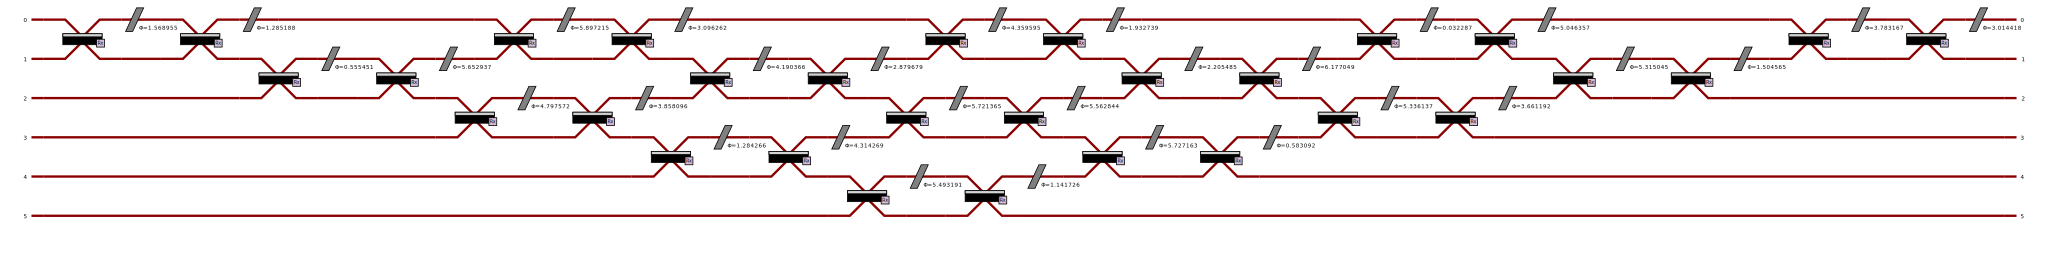

In [16]:
c2 = pcvl.Circuit.decomposition(M, mzi, shape="triangle")
c2.describe()

pcvl.pdisplay(c2)

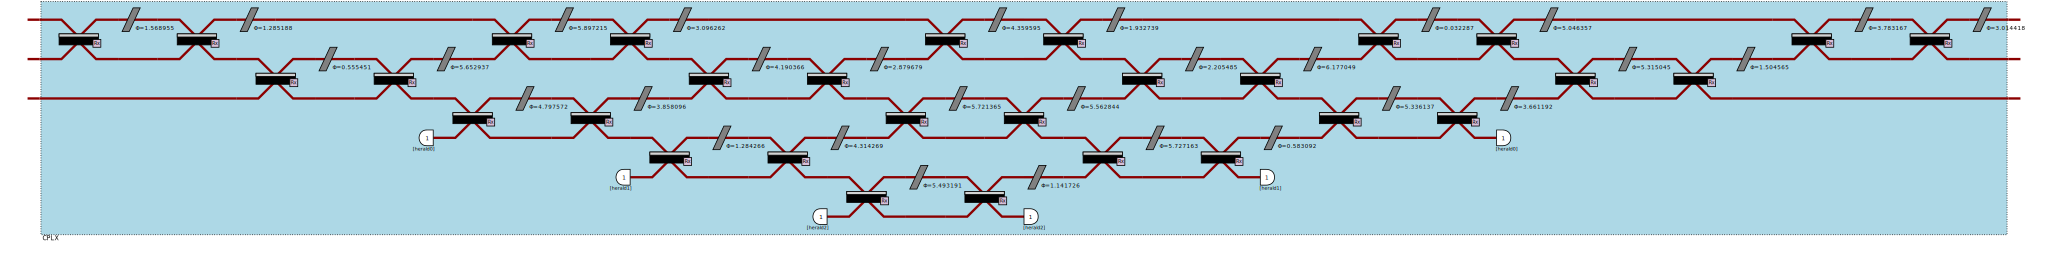

In [22]:
circuit = c2
p = pcvl.Processor("Naive", circuit)
p.add_herald(3,1)  # Third mode is heralded (1 photon in, 1 photon expected out)
p.add_herald(4,1)  # Fourth mode is heralded (1 photon in, 1 photon expected out)
p.add_herald(5,1)  # Fifth mode is heralded (1 photon in, 1 photon expected out)

pcvl.pdisplay(p, recursive=True)


In [ ]:

# After a mode is heralded, you must not take it into account when setting an input to the processor
p.with_input(pcvl.BasicState([0,0,0]))
sampler = pcvl.algorithm.Sampler(p)
probs = sampler.probs()
print("With herald only")
print("Logical perf =", probs['logical_perf'])
print(probs['results'])

# A post-selection function can be created like this:
postselect_func = pcvl.PostSelect("[1] == 1")  # meaning we required 1 photon detection in mode #1

p.set_postselection(postselect_func)  # Add post-selection
probs = sampler.probs()
print("With herald + post-selection function")
print("Logical perf =", probs['logical_perf'])
print(probs['results'])